In [40]:
import yaml
import torch
from claymodel.module import ClayMAEModule
import numpy as np
from pathlib import Path
import datetime
from matplotlib import pyplot as plt
from pyproj import Transformer
import rasterio
from rasterio.plot import show
import copy
from torchvision.transforms import v2
import math
from estuary.util import contrast_stretch
from einops import rearrange
from sklearn import decomposition, svm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support, f1_score, balanced_accuracy_score
from estuary.clay.data import EstuaryDataModule
from estuary.clay.module import EstuaryModule
import tqdm

In [ ]:
# Load model
model = ClayMAEModule.load_from_checkpoint(
    "/Users/kyledorman/data/models/clay/clay-v1.5.ckpt",
    metadata_path="/Users/kyledorman/data/models/clay/metadata.yaml",
    mask_ratio=0.0,
    shuffle=False,
)
_ = model.eval()

In [ ]:
# Load sensor metadata
with open("/Users/kyledorman/data/models/clay/metadata.yaml", "r") as f:
    metadata = yaml.safe_load(f)

channel_4_band_order = [
    'blue',
    'green',
    'red',
    'nir',
]
planetscope = metadata['planetscope-sr']
metadata['planetscope-sr-4'] = {}
metadata['planetscope-sr-4']['band_order'] = channel_4_band_order
metadata['planetscope-sr-4']['rgb_indices'] = [3, 2, 1]
metadata['planetscope-sr-4']['gsd'] = 3
bands = {}
for k, vs in planetscope['bands'].items():
    vs4 = {kk: vv for kk, vv in vs.items() if kk in channel_4_band_order}
    bands[k] = vs4
metadata['planetscope-sr-4']['bands'] = bands

metadata['planetscope-sr-4']

In [2]:
def normalize_latlon(lat, lon):
    """
    Normalize latitude and longitude to a range between -1 and 1.

    Parameters:
    lat (float): Latitude value.
    lon (float): Longitude value.

    Returns:
    tuple: Normalized latitude and longitude values.
    """
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))

def prep_datacube(image, lat, lon, date):
    """
    Prepare a data cube for model input.

    Parameters:
    image (np.array): The input image array.
    lat (float): Latitude value for the location.
    lon (float): Longitude value for the location.

    Returns:
    dict: Prepared data cube with normalized values and embeddings.
    """
    md = metadata['planetscope-sr-4']

    # Extract mean, std, and wavelengths from metadata
    mean = []
    std = []
    waves = []
    bands = md['band_order']
    for band_name in bands:
        mean.append(md['bands']['mean'][band_name])
        std.append(md['bands']['std'][band_name])
        waves.append(md['bands']['wavelength'][band_name] * 1000)

    transform = v2.Compose(
        [
            v2.Resize(size=(128, 128), interpolation=3),
            v2.Normalize(mean=mean, std=std),
        ]
    )

    # Prep datetimes embedding
    times = normalize_timestamp(date)
    week_norm = times[0]
    hour_norm = times[1]

    # Prep lat/lon embedding
    latlons = normalize_latlon(lat, lon)
    lat_norm = latlons[0]
    lon_norm = latlons[1]

    # Prep pixels
    pixels = torch.from_numpy(image.astype(np.float32))
    pixels = transform(pixels)
    pixels = pixels.unsqueeze(0)

    # Prepare additional information
    return {
        "pixels": pixels,
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
        ).unsqueeze(0),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), dtype=torch.float32
        ).unsqueeze(0),
        "waves": torch.tensor(waves),
        "gsd": torch.tensor(md['gsd'] * 2).unsqueeze(0),
    }

In [ ]:
datacube = prep_datacube(data, *cent_g, dt)
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

In [ ]:
# The first embedding is the class token, which is the overall single embedding.
unmsk_patch[:, 0, :].cpu().numpy()

In [ ]:
ep_embedder_cpu = torch.export.load("/Users/kyledorman/data/models/clay/clay-v1.5-encoder_256.pt2").module()

In [ ]:
%%time
datacube = prep_datacube(data, *cent_g, dt)
with torch.no_grad():
    embeddings = ep_embedder_cpu(datacube)
datacube["pixels"].shape, embeddings.shape

In [ ]:
size = 32

embed = rearrange(
    unmsk_patch[:, 1:, :].detach().cpu().numpy(), "b (h w) d-> b d h w", h=size, w=size
)
embed = embed[0]
rows = 4
cols = 4
fig, axs = plt.subplots(cols, cols, figsize=(20, 20))

# idxes = np.random.choice(unmsk_patch.shape[2], rows * cols - 1, replace=False)

for idx, ax in zip(idxes, axs.flatten()[1:]):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)

ax = axs.flatten()[0]
dd = np.log10(1 + data[[3, 2, 1]].clip(1, 2000))
dd = contrast_stretch(dd)
show(dd, ax=ax)
ax.set_axis_off()
ax.set_title(idx)

plt.tight_layout()

In [3]:
labels = pd.read_csv("/Users/kyledorman/data/estuary/label_studio/00025/labels.csv")
labels

,region,source_tif,source_jpeg,label
0,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
1,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,closed
2,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
3,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,closed
4,pismo_creek_lagoon,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
...,...,...,...,...
2995,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
2996,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open
2997,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,closed
2998,little_sur,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open


In [9]:
module = EstuaryModule.load_from_checkpoint(
    "/Users/kyledorman/data/results/estuary/train/20250805-205230/checkpoints/epoch=33-step=5032.ckpt", 
    strict=False)
module.conf.holdout_region = None
module = module.eval()

In [11]:
dm = EstuaryDataModule(module.conf)
dm.prepare_data()
dm.setup()

Some label classes will be ignored {'unsure'}


In [30]:
dl = dm.train_dataloader()

preds = []
labels = []
for batch, blabel in tqdm.tqdm(dl, total=len(dl)):
    for k in batch.keys():
        batch[k] = batch[k].to(module.device)
    pred_batch = module.forward(batch)
    preds.extend(pred_batch.argmax(axis=1).detach().cpu().numpy().tolist())
    labels.extend(blabel.detach().cpu().numpy().tolist())

accuracy_score(labels, preds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [07:50<00:00,  3.18s/it]


0.9639677829588809

In [28]:
dl = dm.val_dataloader()

preds = []
labels = []
for batch, blabel in tqdm.tqdm(dl, total=len(dl)):
    for k in batch.keys():
        batch[k] = batch[k].to(module.device)
    pred_batch = module.forward(batch)
    preds.extend(pred_batch.argmax(axis=1).detach().cpu().numpy().tolist())
    labels.extend(blabel.detach().cpu().numpy().tolist())

accuracy_score(labels, preds)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:47<00:00,  2.49s/it]


0.9525423728813559

In [31]:
dl = dm.test_dataloader()

preds = []
labels = []
for batch, blabel in tqdm.tqdm(dl, total=len(dl)):
    for k in batch.keys():
        batch[k] = batch[k].to(module.device)
    pred_batch = module.forward(batch)
    preds.extend(pred_batch.argmax(axis=1).detach().cpu().numpy().tolist())
    labels.extend(blabel.detach().cpu().numpy().tolist())

accuracy_score(labels, preds)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [01:01<00:00,  3.23s/it]


0.9661016949152542

In [13]:
label_df = dm.test_ds.df
X_test = []
for _, row in label_df.iterrows():
    pth = Path(row.source_jpeg)
    emb_pth = pth.parent.parent / "embeddings" / f"{pth.stem}.npy"
    emb = np.load(emb_pth)
    X_test.append(emb)
X_test = np.array(X_test)
y_test = np.array(label_df.label_idx.tolist())

label_df = dm.train_ds.df
X_train = []
for _, row in label_df.iterrows():
    pth = Path(row.source_jpeg)
    emb_pth = pth.parent.parent / "embeddings" / f"{pth.stem}.npy"
    emb = np.load(emb_pth)
    X_train.append(emb)
X_train = np.array(X_train)
y_train = np.array(label_df.label_idx.tolist())

Matched 227 out of 295 correctly
Accuracy 0.7694915254237288
F1 0.682
Precision 0.762
Recall 0.666


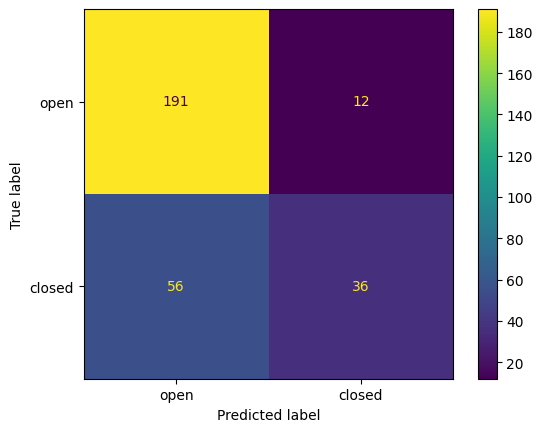

In [22]:
clf = svm.SVC()
# clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict classes on test set
svn_pred = clf.predict(X_test)
y_test = dm.test_ds.df.label_idx
# Perfect match for SVM
match = np.sum(y_test == svn_pred)
print(f"Matched {match} out of {len(X_test)} correctly")

_ = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    svn_pred, 
    labels=list(range(len(["open", "closed"]))),
    display_labels=["open", "closed"],
)

print("Accuracy", accuracy_score(y_test, svn_pred))
prfs = precision_recall_fscore_support(y_test, svn_pred, average='macro')
print("F1", round(prfs[2], 3))
print("Precision", round(prfs[0], 3))
print("Recall", round(prfs[1], 3))

In [33]:
pred_df.label.sum(), pred_df.dnn.sum()

(92, 98)

In [44]:
pred_df

,dnn,svn,label,region,source_jpeg
0,1,0,0,malibu_lagoon,/Users/kyledorman/data/estuary/label_studio/00...
1,0,0,0,russian_river,/Users/kyledorman/data/estuary/label_studio/00...
2,1,1,0,carmel,/Users/kyledorman/data/estuary/label_studio/00...
3,0,0,0,ventura,/Users/kyledorman/data/estuary/label_studio/00...
4,1,1,1,topanga,/Users/kyledorman/data/estuary/label_studio/00...
...,...,...,...,...,...
290,0,0,0,big_sur_river,/Users/kyledorman/data/estuary/label_studio/00...
291,0,0,0,russian_river,/Users/kyledorman/data/estuary/label_studio/00...
292,0,0,0,little_sur,/Users/kyledorman/data/estuary/label_studio/00...
293,1,0,1,navarro_river,/Users/kyledorman/data/estuary/label_studio/00...


In [46]:
pred_df = pd.DataFrame(
    list(zip(
        preds,
        svn_pred,
        dm.test_ds.df.label_idx.tolist(),
        dm.test_ds.df.region.tolist(),
        dm.test_ds.df.source_jpeg.tolist(),
    )), 
    columns=['dnn', 'svn', 'label', 'region', 'source_jpeg']
)
# Define a function to compute accuracy per group
def compute_accuracy(group, pred_col):
    return balanced_accuracy_score(group['label'], group[pred_col])

# Group by region and compute accuracy
dnn_acc_by_region = pred_df.groupby('region').apply(lambda g: compute_accuracy(g, 'dnn'))
svn_acc_by_region = pred_df.groupby('region').apply(lambda g: compute_accuracy(g, 'svn'))
closed_pct = pred_df.groupby('region').apply(lambda g: g.label.sum() / g.label.count())

# Combine into a DataFrame for display
acc_df = pd.DataFrame({
    'dnn': dnn_acc_by_region,
    'svn': svn_acc_by_region,
    "closed_pct": closed_pct,
}).reset_index()

# Show the result
print(acc_df.round(3))

print("dnn", balanced_accuracy_score(pred_df.label, pred_df.dnn))
print("svn", balanced_accuracy_score(pred_df.label, pred_df.svn))

                    region    dnn    svn  closed_pct
0            big_sur_river  0.947  0.947       0.000
1                   carmel  0.938  0.510       0.619
2                   goleta  0.923  0.500       0.278
3               little_sur  1.000  0.500       0.167
4   los_penasquitos_lagoon  1.000  0.500       0.143
5            malibu_lagoon  0.906  0.500       0.333
6            navarro_river  0.923  0.538       0.619
7       pismo_creek_lagoon  1.000  0.455       0.353
8            russian_river  1.000  0.500       0.056
9      san_dieguito_lagoon  1.000  1.000       0.000
10        san_elijo_lagoon  1.000  0.500       0.056
11        san_mateo_lagoon  1.000  0.958       0.857
12         santa_margarita  1.000  0.500       0.059
13                 topanga  0.900  0.538       0.762
14                 ventura  1.000  0.500       0.360
dnn 0.9694260012850717
svn 0.6660955236667381


/Users/kyledorman/Documents/UCLA_kelp/estuary/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kyledorman/Documents/UCLA_kelp/estuary/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/var/folders/pr/1dt1qk511zdgzhfy1xskpqm00000gn/T/ipykernel_65930/2352102153.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dnn_acc_by_region = pred_df.groupby('region'

In [24]:
labels = pd.read_csv("/Users/kyledorman/data/estuary/label_studio/00025/labels.csv")
for r, g in labels.groupby("region"):
    print(r, round((g.label == "closed").sum() / len(g.label), 3))

big_sur_river 0.12
carmel 0.675
goleta 0.22
little_sur 0.24
los_penasquitos_lagoon 0.145
malibu_lagoon 0.405
navarro_river 0.555
pismo_creek_lagoon 0.33
russian_river 0.13
san_dieguito_lagoon 0.0
san_elijo_lagoon 0.075
san_mateo_lagoon 0.85
santa_margarita 0.04
topanga 0.705
ventura 0.145


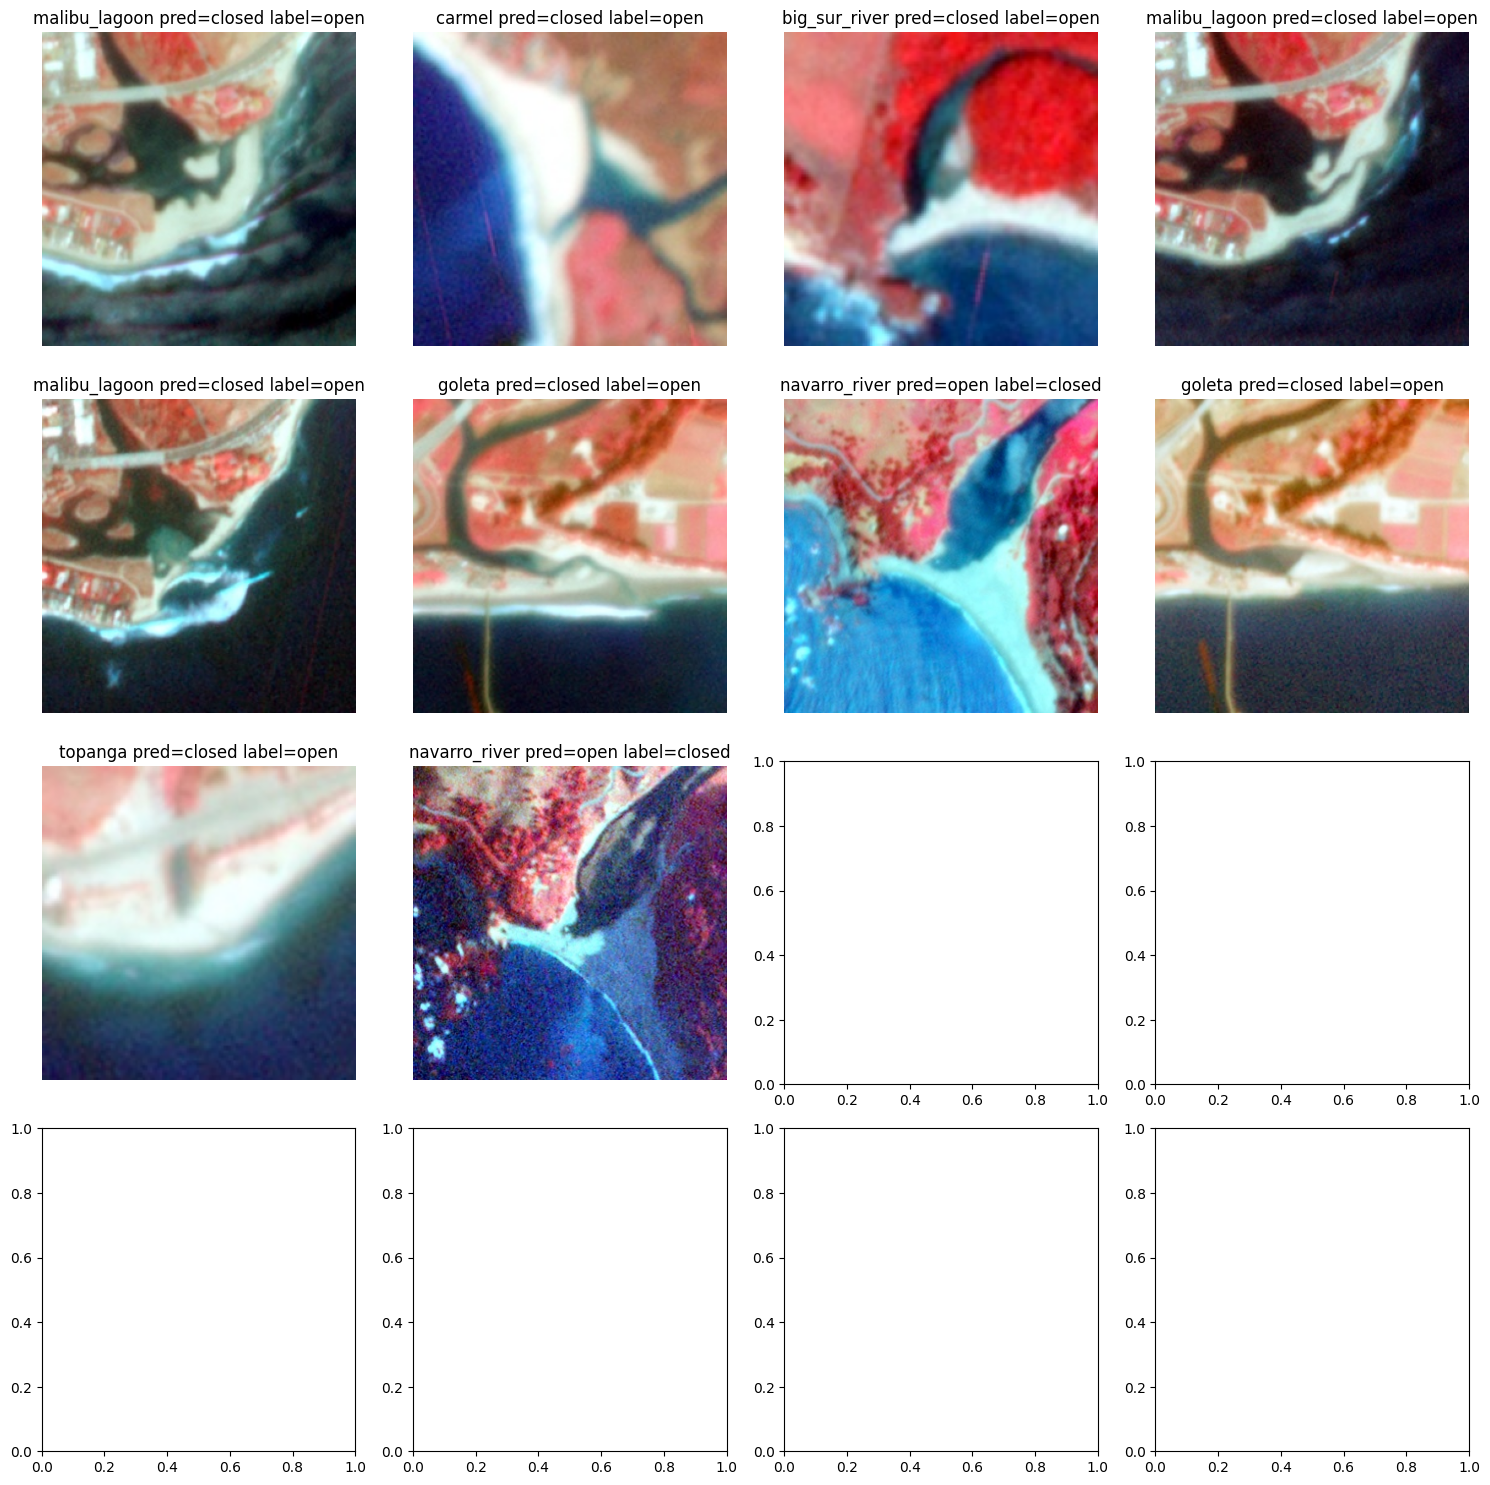

In [27]:
from PIL import Image
aaa = pred_df[(pred_df.dnn != pred_df.label)]

rows = 3
cols = 4
fig, axs = plt.subplots(cols, cols, figsize=(15, 15))

for (idx, row), ax in zip(aaa.iterrows(), axs.flatten()):
    ax.imshow(Image.open(row.source_jpeg))
    ax.set_axis_off()
    ax.set_title(f"{row.region} pred={module.conf.classes[row.dnn]} label={module.conf.classes[row.label]}")

plt.tight_layout()

In [ ]:
dm = 